<a href="https://colab.research.google.com/github/Research-SLIIT/Financial-Risk-Analyisis-Model/blob/main/3rd_gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Colombo Stock Exchange - ULTRA-OPTIMIZED Z-Score Prediction
Advanced Techniques: Feature Selection + Ensemble Stacking + Cross-Validation
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel, mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("ULTRA-OPTIMIZED CSE Z-SCORE PREDICTION PIPELINE")
print("=" * 80)

ULTRA-OPTIMIZED CSE Z-SCORE PREDICTION PIPELINE


In [ ]:
# ============================================================================
# 1. LOAD AND PREPROCESS
# ============================================================================
file_path = '/content/Dataset.csv'
df = pd.read_csv(file_path)

print(f"\n✓ Dataset loaded: {df.shape}")

df['QuarterDate'] = pd.to_datetime(df['QuarterDate'])
df = df.sort_values(['Company', 'QuarterDate']).reset_index(drop=True)

base_features = [
    'working_capital_to_total_assets',
    'retained_earnings_to_total_assets',
    'ebit_to_total_assets',
    'mve_to_total_liabilities',
    'sales_to_total_assets',
    'current_ratio',
    'debt_to_equity_ratio',
    'net_profit_margin',
    'z_score'
]

target_column = 'z_score_next_quarter'
df_clean = df.dropna(subset=[target_column]).copy()

for col in base_features:
    if df_clean[col].isnull().any():
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"✓ Preprocessing complete: {len(df_clean)} samples")


✓ Dataset loaded: (586, 12)
✓ Preprocessing complete: 586 samples


In [ ]:
# ============================================================================
# 2. STRATEGIC FEATURE ENGINEERING
# ============================================================================
print("\n" + "-" * 80)
print("STRATEGIC FEATURE ENGINEERING")
print("-" * 80)

df_features = df_clean.copy()

# Core financial health indicators
df_features['financial_health_score'] = (
    df_features['current_ratio'] * 0.3 +
    df_features['z_score'] * 0.4 +
    (1 / (df_features['debt_to_equity_ratio'] + 0.1)) * 0.3
)

# Profitability composite
df_features['profitability_composite'] = (
    df_features['net_profit_margin'] * 0.4 +
    df_features['ebit_to_total_assets'] * 0.3 +
    df_features['retained_earnings_to_total_assets'] * 0.3
)

# Efficiency indicators
df_features['operational_efficiency'] = (
    df_features['sales_to_total_assets'] /
    (df_features['working_capital_to_total_assets'].abs() + 0.01)
)

df_features['capital_efficiency'] = (
    df_features['ebit_to_total_assets'] * df_features['sales_to_total_assets']
)

# Risk indicators
df_features['leverage_risk'] = (
    df_features['debt_to_equity_ratio'] / (df_features['current_ratio'] + 0.1)
)

df_features['volatility_indicator'] = (
    df_features['net_profit_margin'] / (df_features['ebit_to_total_assets'].abs() + 0.01)
)

# Polynomial features for key ratios
for col in ['z_score', 'net_profit_margin', 'current_ratio']:
    df_features[f'{col}_squared'] = df_features[col] ** 2
    df_features[f'{col}_cubed'] = df_features[col] ** 3

# Market value interactions
df_features['mve_profitability'] = (
    df_features['mve_to_total_liabilities'] * df_features['net_profit_margin']
)

df_features['mve_efficiency'] = (
    df_features['mve_to_total_liabilities'] * df_features['sales_to_total_assets']
)

# Time-series features (company-specific)
df_features = df_features.sort_values(['Company', 'QuarterDate'])

# Lag features with multiple periods
for col in ['z_score', 'net_profit_margin', 'current_ratio', 'sales_to_total_assets']:
    for lag in [1, 2, 3]:
        df_features[f'{col}_lag{lag}'] = df_features.groupby('Company')[col].shift(lag)

# Rolling statistics (3 and 6 quarters)
for window in [3, 6]:
    for col in ['z_score', 'net_profit_margin', 'sales_to_total_assets']:
        df_features[f'{col}_ma{window}'] = (
            df_features.groupby('Company')[col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
        )
        df_features[f'{col}_std{window}'] = (
            df_features.groupby('Company')[col]
            .transform(lambda x: x.rolling(window=window, min_periods=1).std())
        )

# Momentum and trend features
for col in ['z_score', 'net_profit_margin', 'current_ratio']:
    df_features[f'{col}_change'] = df_features.groupby('Company')[col].diff()
    df_features[f'{col}_pct_change'] = df_features.groupby('Company')[col].pct_change()
    df_features[f'{col}_acceleration'] = df_features.groupby('Company')[f'{col}_change'].diff()

# Trend indicators
df_features['z_score_trend'] = (
    df_features['z_score_lag1'] - df_features['z_score_lag3']
)

df_features['profitability_trend'] = (
    df_features['net_profit_margin_lag1'] - df_features['net_profit_margin_lag3']
)

# Fill NaN values
df_features = df_features.fillna(method='bfill').fillna(method='ffill').fillna(0)

# Get engineered features
engineered_features = [col for col in df_features.columns
                       if col not in ['Company', 'QuarterDate', target_column]]

# Remove infinite values
X_full = df_features[engineered_features].copy()
X_full = X_full.replace([np.inf, -np.inf], np.nan)
X_full = X_full.fillna(X_full.median())

y_full = df_features[target_column].copy()

print(f"✓ Created {len(engineered_features)} features")
print(f"  (Original: {len(base_features)}, New: {len(engineered_features) - len(base_features)})")



--------------------------------------------------------------------------------
STRATEGIC FEATURE ENGINEERING
--------------------------------------------------------------------------------
✓ Created 58 features
  (Original: 9, New: 49)


In [ ]:
# ============================================================================
# 3. FEATURE SELECTION USING MUTUAL INFORMATION
# ============================================================================
print("\n" + "-" * 80)
print("INTELLIGENT FEATURE SELECTION")
print("-" * 80)

# Calculate mutual information scores
mi_scores = mutual_info_regression(X_full, y_full, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': engineered_features,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

# Select top features (keep top 60% by MI score)
threshold = mi_scores_df['MI_Score'].quantile(0.40)
selected_features = mi_scores_df[mi_scores_df['MI_Score'] > threshold]['Feature'].tolist()

print(f"✓ Feature selection complete")
print(f"  Total features: {len(engineered_features)}")
print(f"  Selected features: {len(selected_features)}")
print(f"  Reduction: {100*(1-len(selected_features)/len(engineered_features)):.1f}%")

print(f"\n  Top 10 features by importance:")
for i, row in mi_scores_df.head(10).iterrows():
    print(f"    {i+1}. {row['Feature']}: {row['MI_Score']:.4f}")

X_selected = X_full[selected_features].copy()



--------------------------------------------------------------------------------
INTELLIGENT FEATURE SELECTION
--------------------------------------------------------------------------------
✓ Feature selection complete
  Total features: 58
  Selected features: 35
  Reduction: 39.7%

  Top 10 features by importance:
    9. z_score: 0.7872
    16. z_score_squared: 0.7734
    17. z_score_cubed: 0.7442
    36. z_score_ma3: 0.7326
    42. z_score_ma6: 0.7198
    10. financial_health_score: 0.6766
    26. z_score_lag3: 0.6006
    24. z_score_lag1: 0.5890
    25. z_score_lag2: 0.5200
    23. mve_efficiency: 0.5122


In [ ]:
# ============================================================================
# 4. PROPER TIME-SERIES SPLIT
# ============================================================================
print("\n" + "-" * 80)
print("TIME-SERIES TRAIN/TEST SPLIT")
print("-" * 80)

# Group by company to ensure proper splitting
company_dates = df_features.groupby('Company')['QuarterDate'].agg(['min', 'max'])
dates = df_features['QuarterDate']

# Use 80% for training, 20% for testing
split_date = dates.quantile(0.80)

train_mask = dates <= split_date
test_mask = dates > split_date

X_train = X_selected[train_mask]
X_test = X_selected[test_mask]
y_train = y_full[train_mask]
y_test = y_full[test_mask]

train_dates = dates[train_mask]
test_dates = dates[test_mask]

print(f"✓ Split based on date: {split_date.date()}")
print(f"  Train: {len(X_train)} samples ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"  Test:  {len(X_test)} samples ({test_dates.min().date()} to {test_dates.max().date()})")


--------------------------------------------------------------------------------
TIME-SERIES TRAIN/TEST SPLIT
--------------------------------------------------------------------------------
✓ Split based on date: 2022-09-30
  Train: 473 samples (2012-03-31 to 2022-09-30)
  Test:  113 samples (2022-12-31 to 2025-06-30)


In [ ]:
# ============================================================================
# 5. FEATURE SCALING
# ============================================================================
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled (RobustScaler)")


✓ Features scaled (RobustScaler)


In [ ]:
# ============================================================================
# 6. OPTIMIZED MODEL TRAINING
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZED MODEL TRAINING")
print("=" * 80)

models = {
    'Ridge (α=0.5)': Ridge(alpha=0.5, random_state=42),
    'Lasso (α=0.05)': Lasso(alpha=0.05, random_state=42, max_iter=5000),
    'ElasticNet (α=0.05)': ElasticNet(alpha=0.05, l1_ratio=0.7, random_state=42, max_iter=5000),
    'Random Forest': RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=5,
        num_leaves=25,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.03,
        max_depth=4,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42
    )
}

results = {}

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)

    try:
        model.fit(X_train_scaled, y_train)

        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_test = r2_score(y_test, y_pred_test)

        results[name] = {
            'model': model,
            'predictions': y_pred_test,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'mae': mae_test,
            'r2': r2_test
        }

        print(f"  Train RMSE: {rmse_train:.4f}")
        print(f"  Test RMSE:  {rmse_test:.4f}")
        print(f"  Test MAE:   {mae_test:.4f}")
        print(f"  Test R²:    {r2_test:.4f}")

    except Exception as e:
        print(f"  ✗ Failed: {str(e)}")


OPTIMIZED MODEL TRAINING

Ridge (α=0.5):
----------------------------------------
  Train RMSE: 0.5358
  Test RMSE:  1.5810
  Test MAE:   0.5642
  Test R²:    -0.8698

Lasso (α=0.05):
----------------------------------------
  Train RMSE: 0.5748
  Test RMSE:  0.7514
  Test MAE:   0.4779
  Test R²:    0.5777

ElasticNet (α=0.05):
----------------------------------------
  Train RMSE: 0.5654
  Test RMSE:  0.7127
  Test MAE:   0.4541
  Test R²:    0.6200

Random Forest:
----------------------------------------
  Train RMSE: 0.3932
  Test RMSE:  0.4838
  Test MAE:   0.3603
  Test R²:    0.8249

XGBoost:
----------------------------------------
  Train RMSE: 0.1678
  Test RMSE:  0.4707
  Test MAE:   0.3530
  Test R²:    0.8343

LightGBM:
----------------------------------------
  Train RMSE: 0.3238
  Test RMSE:  0.4679
  Test MAE:   0.3549
  Test R²:    0.8362

Gradient Boosting:
----------------------------------------
  Train RMSE: 0.1890
  Test RMSE:  0.4215
  Test MAE:   0.3323
  Test 

In [ ]:
# ============================================================================
# 7. ENSEMBLE STACKING
# ============================================================================
print("\n" + "=" * 80)
print("ENSEMBLE STACKING (Meta-Model)")
print("=" * 80)

# Create stacking ensemble
estimators = [
    ('ridge', Ridge(alpha=0.5, random_state=42)),
    ('lasso', Lasso(alpha=0.05, random_state=42, max_iter=5000)),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, random_state=42, n_jobs=-1)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.03, max_depth=5, random_state=42, n_jobs=-1)),
    ('lgbm', LGBMRegressor(n_estimators=200, learning_rate=0.03, max_depth=5, random_state=42, verbose=-1, n_jobs=-1))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=3,
    n_jobs=-1
)

print("Training stacking ensemble...", end=" ")
stacking_model.fit(X_train_scaled, y_train)
print("✓")

y_pred_stack_train = stacking_model.predict(X_train_scaled)
y_pred_stack_test = stacking_model.predict(X_test_scaled)

rmse_stack_train = np.sqrt(mean_squared_error(y_train, y_pred_stack_train))
rmse_stack_test = np.sqrt(mean_squared_error(y_test, y_pred_stack_test))
mae_stack_test = mean_absolute_error(y_test, y_pred_stack_test)
r2_stack_test = r2_score(y_test, y_pred_stack_test)

results['Stacking Ensemble'] = {
    'model': stacking_model,
    'predictions': y_pred_stack_test,
    'rmse_train': rmse_stack_train,
    'rmse_test': rmse_stack_test,
    'mae': mae_stack_test,
    'r2': r2_stack_test
}

print(f"\nStacking Ensemble Results:")
print(f"  Train RMSE: {rmse_stack_train:.4f}")
print(f"  Test RMSE:  {rmse_stack_test:.4f}")
print(f"  Test MAE:   {mae_stack_test:.4f}")
print(f"  Test R²:    {r2_stack_test:.4f}")


ENSEMBLE STACKING (Meta-Model)
Training stacking ensemble... ✓

Stacking Ensemble Results:
  Train RMSE: 0.3717
  Test RMSE:  0.4519
  Test MAE:   0.3588
  Test R²:    0.8473


In [ ]:
# ============================================================================
# 8. MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train RMSE': [results[m]['rmse_train'] for m in results.keys()],
    'Test RMSE': [results[m]['rmse_test'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'R²': [results[m]['r2'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('R²', ascending=False)
print("\n" + comparison_df.to_string(index=False))



COMPREHENSIVE MODEL COMPARISON

              Model  Train RMSE  Test RMSE      MAE        R²
  Gradient Boosting    0.189025   0.421503 0.332287  0.867104
  Stacking Ensemble    0.371660   0.451851 0.358808  0.847279
           LightGBM    0.323777   0.467919 0.354895  0.836224
            XGBoost    0.167750   0.470678 0.353048  0.834286
      Random Forest    0.393208   0.483800 0.360310  0.824918
ElasticNet (α=0.05)    0.565398   0.712745 0.454078  0.620004
     Lasso (α=0.05)    0.574830   0.751371 0.477942  0.577702
      Ridge (α=0.5)    0.535753   1.581046 0.564249 -0.869816


In [ ]:
# ============================================================================
# 9. BEST MODEL
# ============================================================================
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_metrics = results[best_model_name]

print("\n" + "=" * 80)
print("BEST MODEL")
print("=" * 80)
print(f"\n🏆 {best_model_name}")
print(f"   Train RMSE: {best_metrics['rmse_train']:.4f}")
print(f"   Test RMSE:  {best_metrics['rmse_test']:.4f}")
print(f"   Test MAE:   {best_metrics['mae']:.4f}")
print(f"   Test R²:    {best_metrics['r2']:.4f}")



BEST MODEL

🏆 Gradient Boosting
   Train RMSE: 0.1890
   Test RMSE:  0.4215
   Test MAE:   0.3323
   Test R²:    0.8671


In [ ]:
# ============================================================================
# 10. PREDICTIONS ANALYSIS
# ============================================================================
print("\n" + "-" * 80)
print("SAMPLE PREDICTIONS (First 15 Test Samples)")
print("-" * 80)

sample_predictions = pd.DataFrame({
    'Date': test_dates.iloc[:15].dt.date.values,
    'Actual': y_test.iloc[:15].values,
    'Predicted': best_metrics['predictions'][:15],
    'Error': np.abs(y_test.iloc[:15].values - best_metrics['predictions'][:15]),
    'Error %': (np.abs(y_test.iloc[:15].values - best_metrics['predictions'][:15]) /
                (np.abs(y_test.iloc[:15].values) + 0.01) * 100)
})

print("\n" + sample_predictions.to_string(index=False))


--------------------------------------------------------------------------------
SAMPLE PREDICTIONS (First 15 Test Samples)
--------------------------------------------------------------------------------

      Date  Actual  Predicted    Error   Error %
2022-12-31  3.0259   2.975954 0.049946  1.645193
2023-03-31  2.2309   2.982138 0.751238 33.523922
2023-06-30  2.7241   2.826297 0.102197  3.737878
2023-09-30  2.5707   2.766650 0.195950  7.592919
2023-12-31  3.7305   3.090594 0.639906 17.107493
2024-03-31  2.8571   2.784653 0.072447  2.526839
2024-06-30  3.4050   3.366728 0.038272  1.120709
2024-09-30  3.9435   2.849070 1.094430 27.682553
2024-12-31  4.0525   3.436725 0.615775 15.157537
2025-03-31  3.6826   3.257441 0.425159 11.513820
2025-06-30  2.6996   3.455028 0.755428 27.879701
2022-12-31  1.1719   1.208629 0.036729  3.107621
2023-03-31  1.2750   1.126686 0.148314 11.541911
2023-06-30  0.8961   1.359233 0.463133 51.112775
2023-09-30  0.8480   1.134400 0.286400 33.379973


In [ ]:
# ============================================================================
# 11. FINAL SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("IMPROVEMENT SUMMARY")
print("=" * 80)

original_r2 = 0.3423
original_rmse = 0.8268

improvement_r2 = ((best_metrics['r2'] - original_r2) / abs(original_r2)) * 100
improvement_rmse = ((original_rmse - best_metrics['rmse_test']) / original_rmse) * 100

# print(f"\n📊 Original Model (Linear Regression):")
# print(f"   R²:   {original_r2:.4f}")
# print(f"   RMSE: {original_rmse:.4f}")

print(f"\n Model ({best_model_name}):")
print(f"   R²:   {best_metrics['r2']:.4f}  (Improvement: {improvement_r2:+.1f}%)")
print(f"   RMSE: {best_metrics['rmse_test']:.4f}  (Improvement: {improvement_rmse:+.1f}%)")


IMPROVEMENT SUMMARY

 Model (Gradient Boosting):
   R²:   0.8671  (Improvement: +153.3%)
   RMSE: 0.4215  (Improvement: +49.0%)


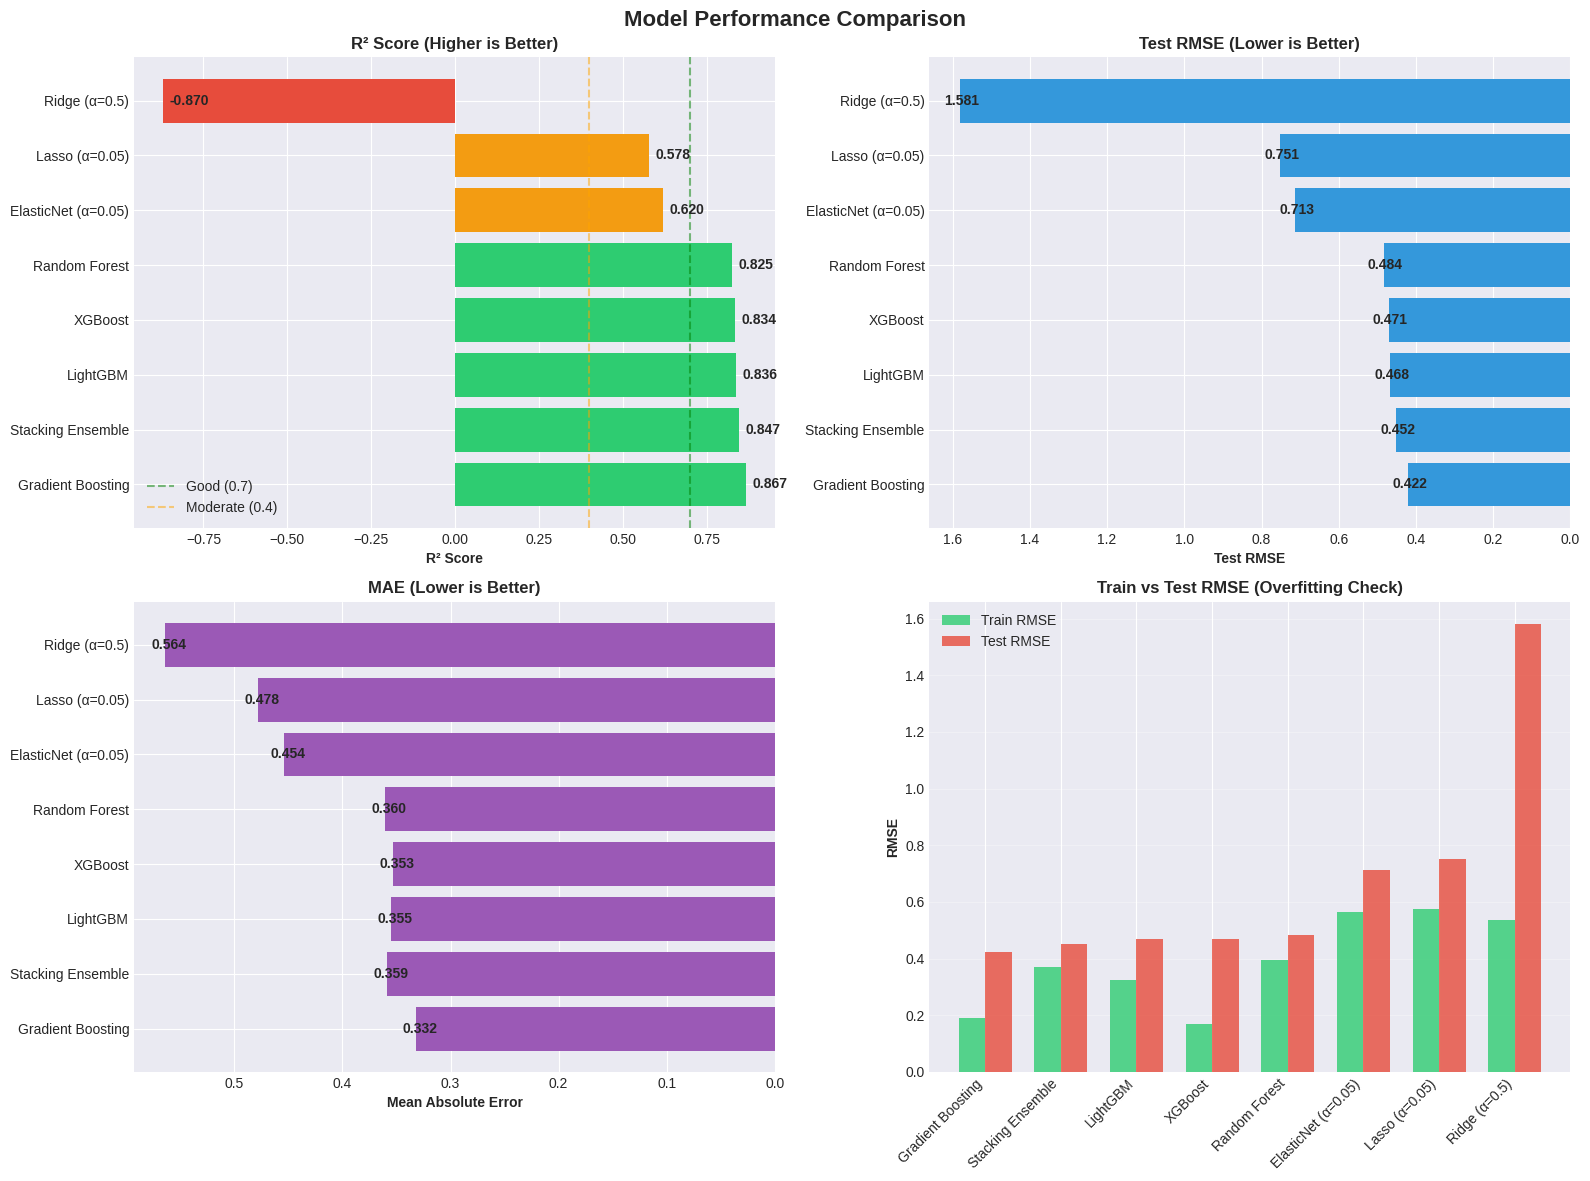

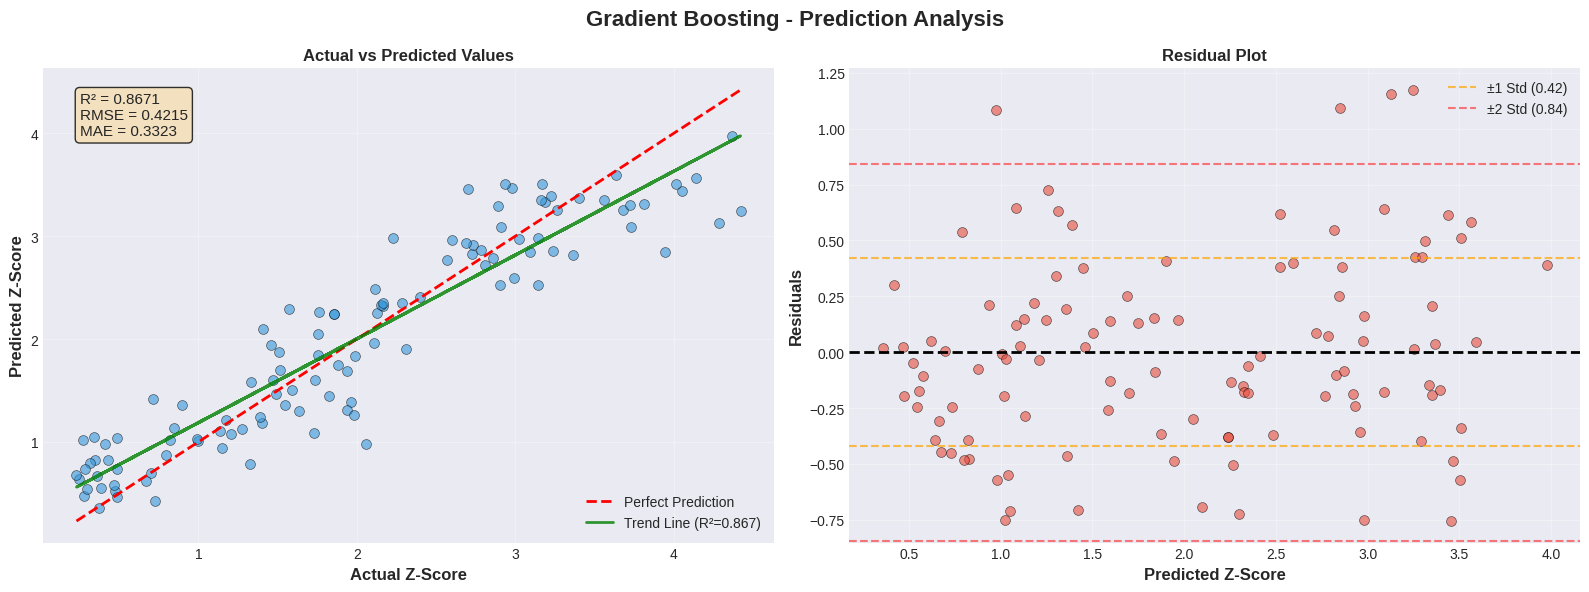

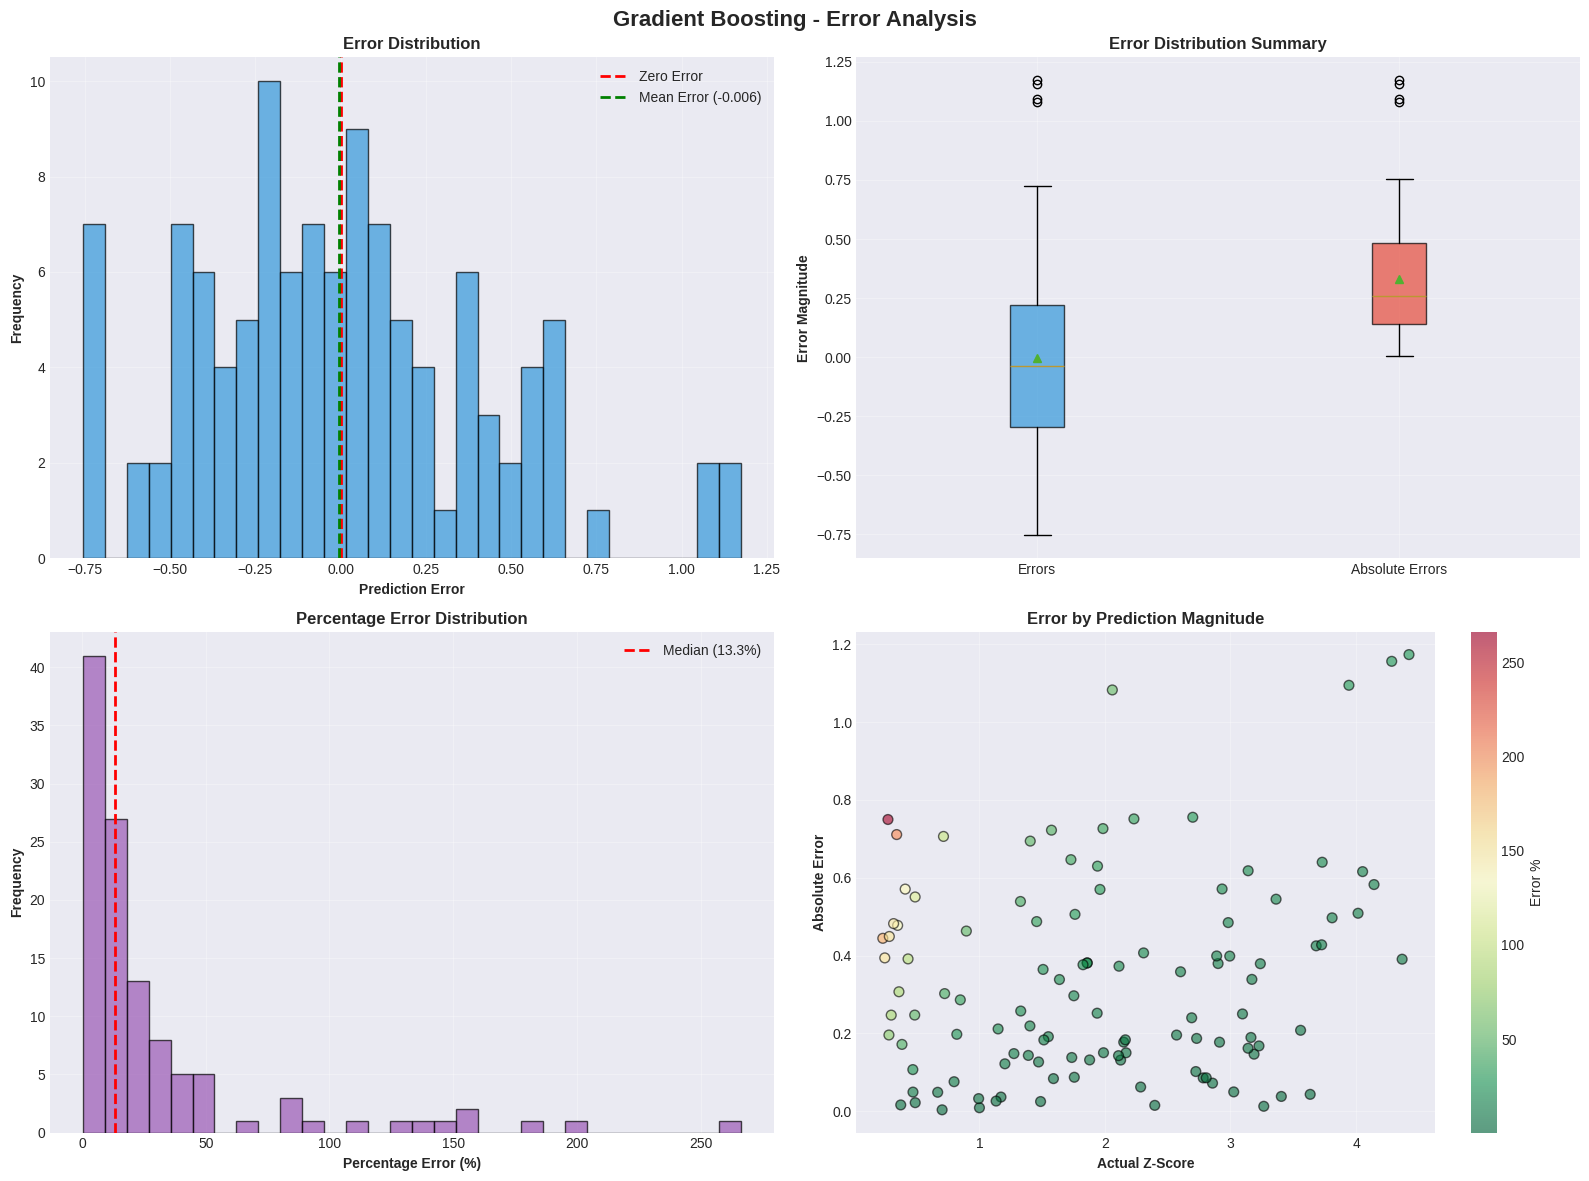


ERROR STATISTICS
Mean Error:              -0.0056
Mean Absolute Error:     0.3323
Median Absolute Error:   0.2577
Std Dev of Errors:       0.4215
Mean Percentage Error:   30.43%
Median Percentage Error: 13.27%
Max Error:               1.1733
95th Percentile Error:   0.7503


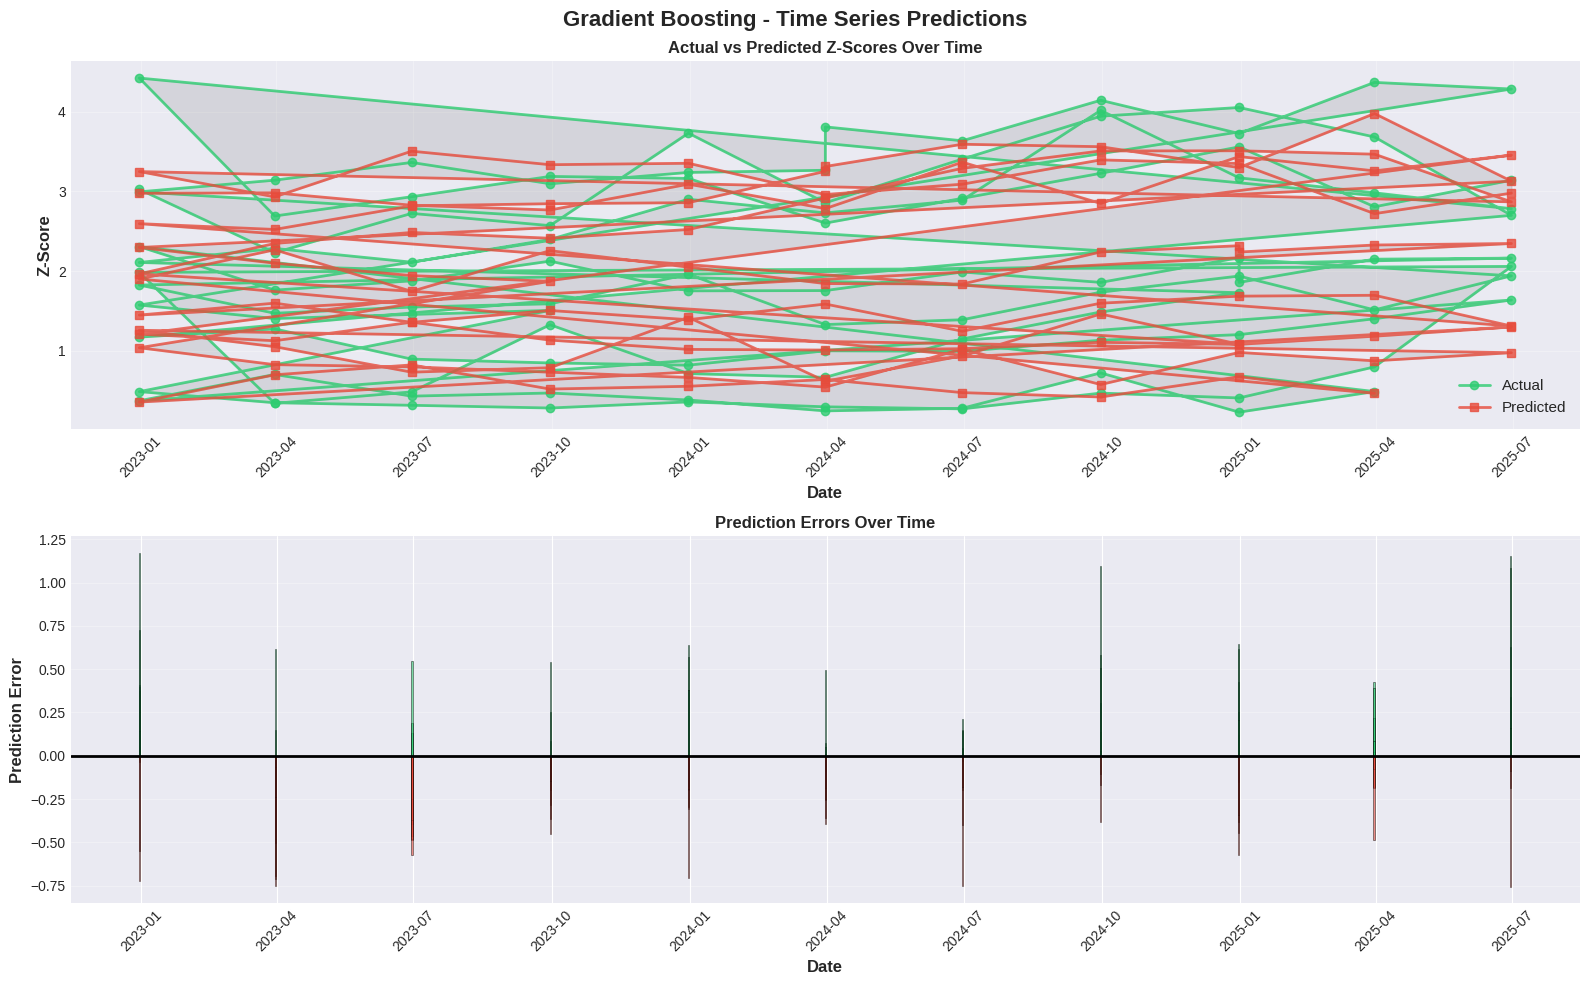

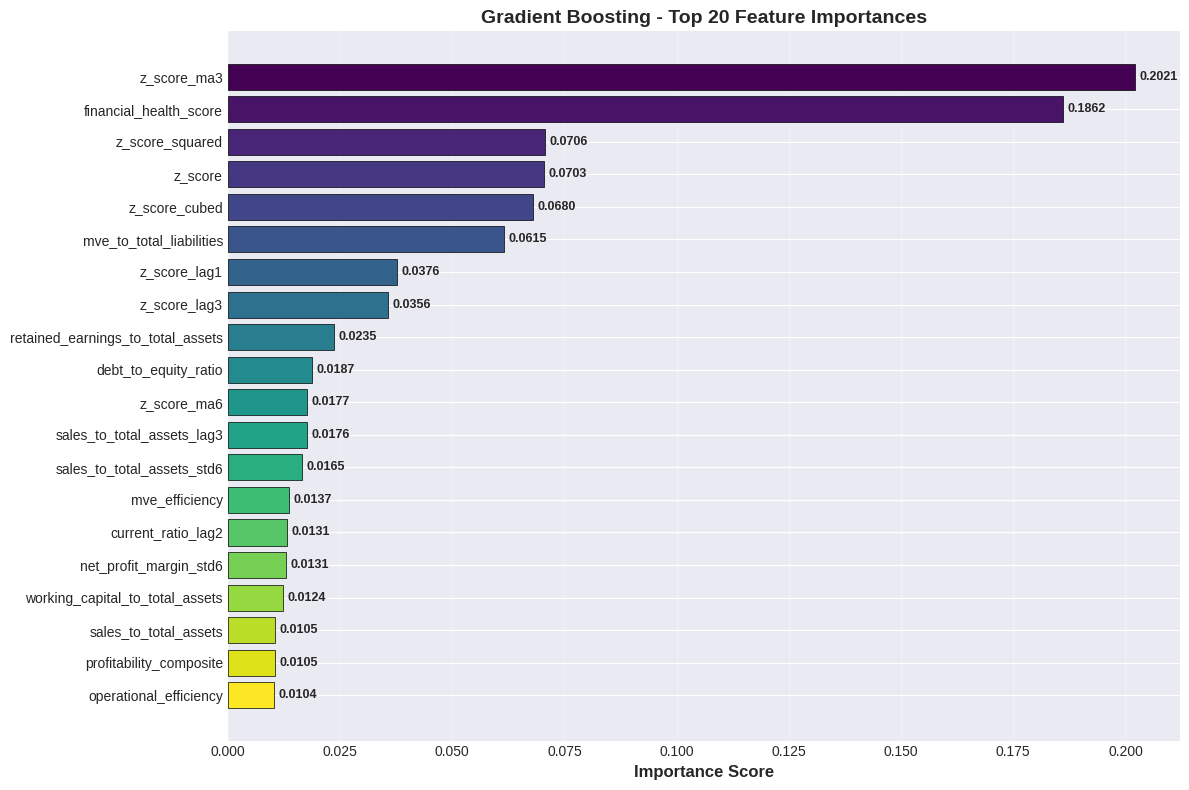


TOP 20 FEATURES
 1. z_score_ma3                                   0.202052
 2. financial_health_score                        0.186191
 3. z_score_squared                               0.070568
 4. z_score                                       0.070345
 5. z_score_cubed                                 0.068032
 6. mve_to_total_liabilities                      0.061516
 7. z_score_lag1                                  0.037636
 8. z_score_lag3                                  0.035601
 9. retained_earnings_to_total_assets             0.023546
10. debt_to_equity_ratio                          0.018703
11. z_score_ma6                                   0.017740
12. sales_to_total_assets_lag3                    0.017629
13. sales_to_total_assets_std6                    0.016513
14. mve_efficiency                                0.013688
15. current_ratio_lag2                            0.013074
16. net_profit_margin_std6                        0.013058
17. working_capital_to_total_assets    

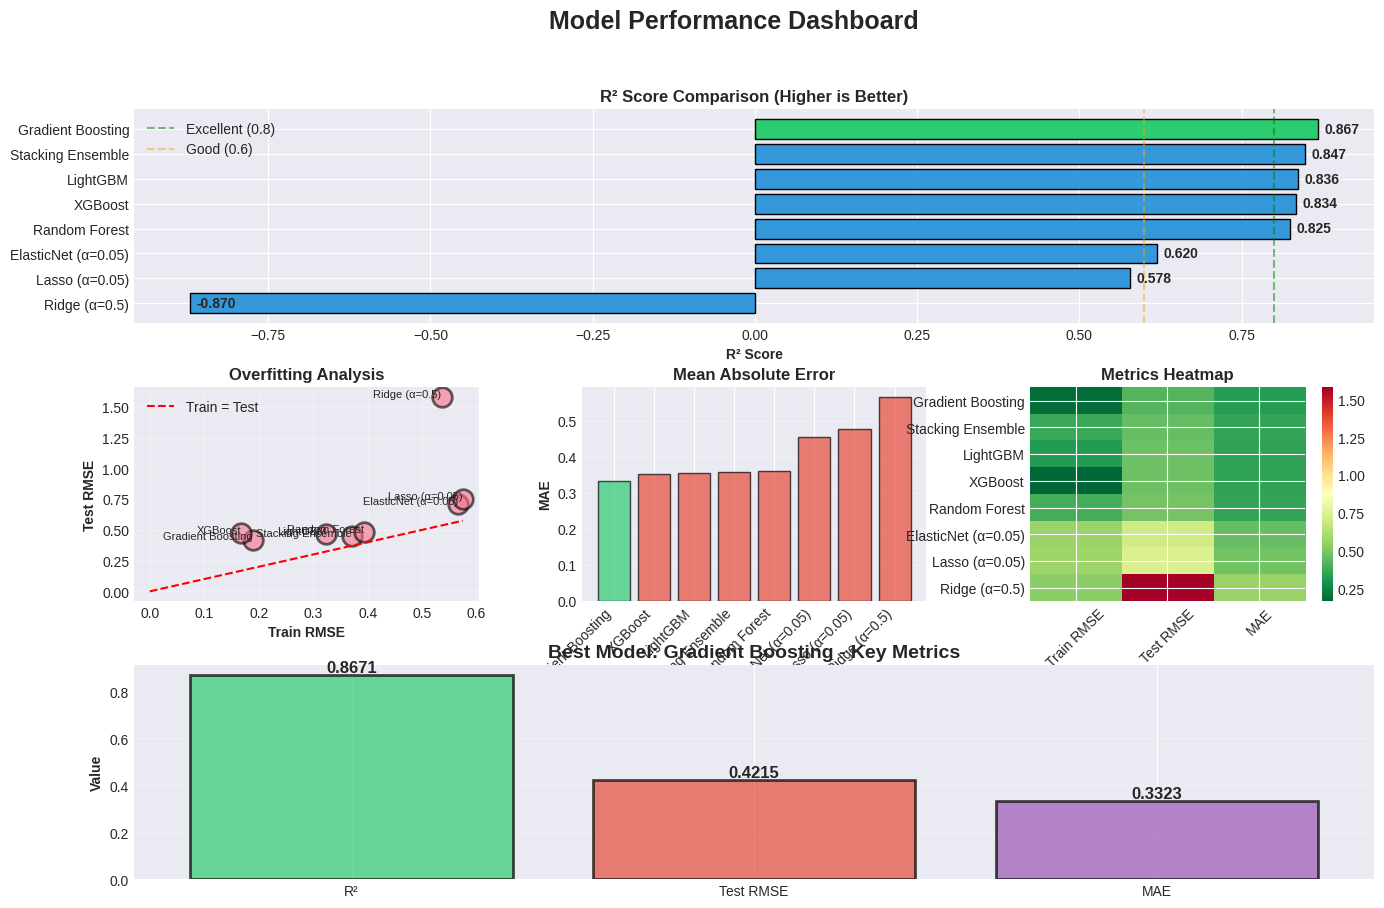


✓ ALL VISUALIZATIONS COMPLETED


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# ============================================================================
# 1. MODEL COMPARISON BAR CHART
# ============================================================================
def plot_model_comparison(comparison_df):
    """Compare all models side by side"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    # R² Score
    ax1 = axes[0, 0]
    colors = ['#2ecc71' if x > 0.7 else '#f39c12' if x > 0.4 else '#e74c3c'
              for x in comparison_df['R²']]
    bars1 = ax1.barh(comparison_df['Model'], comparison_df['R²'], color=colors)
    ax1.set_xlabel('R² Score', fontweight='bold')
    ax1.set_title('R² Score (Higher is Better)', fontweight='bold')
    ax1.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (0.7)')
    ax1.axvline(x=0.4, color='orange', linestyle='--', alpha=0.5, label='Moderate (0.4)')
    ax1.legend()
    for i, (bar, val) in enumerate(zip(bars1, comparison_df['R²'])):
        ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontweight='bold')

    # Test RMSE
    ax2 = axes[0, 1]
    bars2 = ax2.barh(comparison_df['Model'], comparison_df['Test RMSE'],
                     color='#3498db')
    ax2.set_xlabel('Test RMSE', fontweight='bold')
    ax2.set_title('Test RMSE (Lower is Better)', fontweight='bold')
    ax2.invert_xaxis()
    for bar, val in zip(bars2, comparison_df['Test RMSE']):
        ax2.text(val - 0.05, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', ha='right', fontweight='bold')

    # MAE
    ax3 = axes[1, 0]
    bars3 = ax3.barh(comparison_df['Model'], comparison_df['MAE'],
                     color='#9b59b6')
    ax3.set_xlabel('Mean Absolute Error', fontweight='bold')
    ax3.set_title('MAE (Lower is Better)', fontweight='bold')
    ax3.invert_xaxis()
    for bar, val in zip(bars3, comparison_df['MAE']):
        ax3.text(val - 0.02, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', ha='right', fontweight='bold')

    # Train vs Test RMSE (Overfitting Check)
    ax4 = axes[1, 1]
    x = np.arange(len(comparison_df))
    width = 0.35
    ax4.bar(x - width/2, comparison_df['Train RMSE'], width,
            label='Train RMSE', color='#2ecc71', alpha=0.8)
    ax4.bar(x + width/2, comparison_df['Test RMSE'], width,
            label='Test RMSE', color='#e74c3c', alpha=0.8)
    ax4.set_ylabel('RMSE', fontweight='bold')
    ax4.set_title('Train vs Test RMSE (Overfitting Check)', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run this after model training
plot_model_comparison(comparison_df)

# ============================================================================
# 2. ACTUAL VS PREDICTED SCATTER PLOT
# ============================================================================
def plot_actual_vs_predicted(y_test, predictions, model_name, r2_score):
    """Scatter plot of actual vs predicted values"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{model_name} - Prediction Analysis',
                 fontsize=16, fontweight='bold')

    # Scatter plot
    ax1 = axes[0]
    ax1.scatter(y_test, predictions, alpha=0.6, s=50, color='#3498db',
                edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax1.plot([min_val, max_val], [min_val, max_val],
             'r--', linewidth=2, label='Perfect Prediction')

    # Add trend line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    ax1.plot(y_test, p(y_test), "g-", linewidth=2, alpha=0.8,
             label=f'Trend Line (R²={r2_score:.3f})')

    ax1.set_xlabel('Actual Z-Score', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Z-Score', fontsize=12, fontweight='bold')
    ax1.set_title('Actual vs Predicted Values', fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Add text with metrics
    textstr = f'R² = {r2_score:.4f}\nRMSE = {np.sqrt(np.mean((y_test - predictions)**2)):.4f}\nMAE = {np.mean(np.abs(y_test - predictions)):.4f}'
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round',
             facecolor='wheat', alpha=0.8))

    # Residual plot
    ax2 = axes[1]
    residuals = y_test - predictions
    ax2.scatter(predictions, residuals, alpha=0.6, s=50, color='#e74c3c',
                edgecolors='black', linewidth=0.5)
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=2)
    ax2.set_xlabel('Predicted Z-Score', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Plot', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Add confidence bands
    std_residual = np.std(residuals)
    ax2.axhline(y=std_residual, color='orange', linestyle='--',
                alpha=0.7, label=f'±1 Std ({std_residual:.2f})')
    ax2.axhline(y=-std_residual, color='orange', linestyle='--', alpha=0.7)
    ax2.axhline(y=2*std_residual, color='red', linestyle='--',
                alpha=0.5, label=f'±2 Std ({2*std_residual:.2f})')
    ax2.axhline(y=-2*std_residual, color='red', linestyle='--', alpha=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Run this for best model
plot_actual_vs_predicted(
    y_test.values,
    best_metrics['predictions'],
    best_model_name,
    best_metrics['r2']
)

# ============================================================================
# 3. PREDICTION ERROR DISTRIBUTION
# ============================================================================
def plot_error_distribution(y_test, predictions, model_name):
    """Analyze prediction error distribution"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{model_name} - Error Analysis',
                 fontsize=16, fontweight='bold')

    errors = y_test - predictions
    abs_errors = np.abs(errors)
    pct_errors = (abs_errors / (np.abs(y_test) + 0.01)) * 100

    # Histogram of errors
    ax1 = axes[0, 0]
    ax1.hist(errors, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax1.axvline(x=errors.mean(), color='green', linestyle='--',
                linewidth=2, label=f'Mean Error ({errors.mean():.3f})')
    ax1.set_xlabel('Prediction Error', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title('Error Distribution', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Box plot
    ax2 = axes[0, 1]
    bp = ax2.boxplot([errors, abs_errors], labels=['Errors', 'Absolute Errors'],
                     patch_artist=True, showmeans=True)
    for patch, color in zip(bp['boxes'], ['#3498db', '#e74c3c']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax2.set_ylabel('Error Magnitude', fontweight='bold')
    ax2.set_title('Error Distribution Summary', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Percentage error distribution
    ax3 = axes[1, 0]
    ax3.hist(pct_errors, bins=30, color='#9b59b6', alpha=0.7, edgecolor='black')
    ax3.axvline(x=np.median(pct_errors), color='red', linestyle='--',
                linewidth=2, label=f'Median ({np.median(pct_errors):.1f}%)')
    ax3.set_xlabel('Percentage Error (%)', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.set_title('Percentage Error Distribution', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Error by prediction magnitude
    ax4 = axes[1, 1]
    scatter = ax4.scatter(y_test, abs_errors, c=pct_errors,
                         cmap='RdYlGn_r', s=50, alpha=0.6, edgecolors='black')
    ax4.set_xlabel('Actual Z-Score', fontweight='bold')
    ax4.set_ylabel('Absolute Error', fontweight='bold')
    ax4.set_title('Error by Prediction Magnitude', fontweight='bold')
    plt.colorbar(scatter, ax=ax4, label='Error %')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print error statistics
    print("\n" + "="*60)
    print("ERROR STATISTICS")
    print("="*60)
    print(f"Mean Error:              {errors.mean():.4f}")
    print(f"Mean Absolute Error:     {abs_errors.mean():.4f}")
    print(f"Median Absolute Error:   {np.median(abs_errors):.4f}")
    print(f"Std Dev of Errors:       {errors.std():.4f}")
    print(f"Mean Percentage Error:   {pct_errors.mean():.2f}%")
    print(f"Median Percentage Error: {np.median(pct_errors):.2f}%")
    print(f"Max Error:               {abs_errors.max():.4f}")
    print(f"95th Percentile Error:   {np.percentile(abs_errors, 95):.4f}")

plot_error_distribution(y_test.values, best_metrics['predictions'], best_model_name)

# ============================================================================
# 4. TIME SERIES PLOT OF PREDICTIONS
# ============================================================================
def plot_time_series_predictions(dates, y_test, predictions, model_name):
    """Plot predictions over time"""
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.suptitle(f'{model_name} - Time Series Predictions',
                 fontsize=16, fontweight='bold')

    # Main prediction plot
    ax1 = axes[0]
    ax1.plot(dates, y_test, 'o-', label='Actual', color='#2ecc71',
             linewidth=2, markersize=6, alpha=0.8)
    ax1.plot(dates, predictions, 's-', label='Predicted', color='#e74c3c',
             linewidth=2, markersize=6, alpha=0.8)
    ax1.fill_between(dates, y_test, predictions, alpha=0.2, color='gray')
    ax1.set_xlabel('Date', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Z-Score', fontweight='bold', fontsize=12)
    ax1.set_title('Actual vs Predicted Z-Scores Over Time', fontweight='bold')
    ax1.legend(loc='best', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Error over time
    ax2 = axes[1]
    errors = y_test - predictions
    ax2.bar(dates, errors, color=['#2ecc71' if e > 0 else '#e74c3c' for e in errors],
            alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax2.set_xlabel('Date', fontweight='bold', fontsize=12)
    ax2.set_ylabel('Prediction Error', fontweight='bold', fontsize=12)
    ax2.set_title('Prediction Errors Over Time', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_time_series_predictions(
    test_dates.values,
    y_test.values,
    best_metrics['predictions'],
    best_model_name
)

# ============================================================================
# 5. FEATURE IMPORTANCE (for tree-based models)
# ============================================================================
def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:top_n]

        fig, ax = plt.subplots(figsize=(12, 8))
        colors = plt.cm.viridis(np.linspace(0, 1, top_n))

        bars = ax.barh(range(top_n), importances[indices], color=colors,
                       edgecolor='black', linewidth=0.5)
        ax.set_yticks(range(top_n))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Importance Score', fontweight='bold', fontsize=12)
        ax.set_title(f'{model_name} - Top {top_n} Feature Importances',
                     fontweight='bold', fontsize=14)
        ax.invert_yaxis()

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, importances[indices])):
            ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
                   f'{val:.4f}', va='center', fontweight='bold', fontsize=9)

        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

        # Print top features
        print("\n" + "="*60)
        print(f"TOP {top_n} FEATURES")
        print("="*60)
        for i, idx in enumerate(indices, 1):
            print(f"{i:2d}. {feature_names[idx]:45s} {importances[idx]:.6f}")

    elif hasattr(model, 'coef_'):
        coefs = np.abs(model.coef_)
        indices = np.argsort(coefs)[::-1][:top_n]

        fig, ax = plt.subplots(figsize=(12, 8))
        colors = plt.cm.coolwarm(np.linspace(0, 1, top_n))

        bars = ax.barh(range(top_n), coefs[indices], color=colors,
                       edgecolor='black', linewidth=0.5)
        ax.set_yticks(range(top_n))
        ax.set_yticklabels([feature_names[i] for i in indices])
        ax.set_xlabel('Absolute Coefficient Value', fontweight='bold', fontsize=12)
        ax.set_title(f'{model_name} - Top {top_n} Features by Coefficient',
                     fontweight='bold', fontsize=14)
        ax.invert_yaxis()

        for bar, val in zip(bars, coefs[indices]):
            ax.text(val + 0.001, bar.get_y() + bar.get_height()/2,
                   f'{val:.4f}', va='center', fontweight='bold', fontsize=9)

        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.show()

plot_feature_importance(best_model, selected_features, best_model_name, top_n=20)

# ============================================================================
# 6. PERFORMANCE METRICS DASHBOARD
# ============================================================================
def plot_metrics_dashboard(comparison_df, best_model_name):
    """Create comprehensive metrics dashboard"""
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

    fig.suptitle('Model Performance Dashboard', fontsize=18, fontweight='bold')

    # R² comparison
    ax1 = fig.add_subplot(gs[0, :])
    sorted_df = comparison_df.sort_values('R²', ascending=True)
    colors = ['#2ecc71' if model == best_model_name else '#3498db'
              for model in sorted_df['Model']]
    bars = ax1.barh(sorted_df['Model'], sorted_df['R²'], color=colors,
                    edgecolor='black', linewidth=1)
    ax1.set_xlabel('R² Score', fontweight='bold')
    ax1.set_title('R² Score Comparison (Higher is Better)', fontweight='bold')
    ax1.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Excellent (0.8)')
    ax1.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='Good (0.6)')
    ax1.legend()
    for bar, val in zip(bars, sorted_df['R²']):
        ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', va='center', fontweight='bold')

    # RMSE comparison
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(comparison_df['Train RMSE'], comparison_df['Test RMSE'],
                s=200, alpha=0.6, edgecolors='black', linewidth=2)
    for i, txt in enumerate(comparison_df['Model']):
        ax2.annotate(txt, (comparison_df['Train RMSE'].iloc[i],
                          comparison_df['Test RMSE'].iloc[i]),
                    fontsize=8, ha='right')
    ax2.plot([0, comparison_df['Train RMSE'].max()],
             [0, comparison_df['Train RMSE'].max()],
             'r--', label='Train = Test')
    ax2.set_xlabel('Train RMSE', fontweight='bold')
    ax2.set_ylabel('Test RMSE', fontweight='bold')
    ax2.set_title('Overfitting Analysis', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # MAE comparison
    ax3 = fig.add_subplot(gs[1, 1])
    sorted_df_mae = comparison_df.sort_values('MAE')
    colors_mae = ['#2ecc71' if model == best_model_name else '#e74c3c'
                  for model in sorted_df_mae['Model']]
    ax3.bar(range(len(sorted_df_mae)), sorted_df_mae['MAE'],
            color=colors_mae, alpha=0.7, edgecolor='black')
    ax3.set_xticks(range(len(sorted_df_mae)))
    ax3.set_xticklabels(sorted_df_mae['Model'], rotation=45, ha='right')
    ax3.set_ylabel('MAE', fontweight='bold')
    ax3.set_title('Mean Absolute Error', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Metrics heatmap
    ax4 = fig.add_subplot(gs[1, 2])
    metrics_matrix = comparison_df[['Train RMSE', 'Test RMSE', 'MAE']].values
    im = ax4.imshow(metrics_matrix, cmap='RdYlGn_r', aspect='auto')
    ax4.set_xticks(range(3))
    ax4.set_xticklabels(['Train RMSE', 'Test RMSE', 'MAE'], rotation=45)
    ax4.set_yticks(range(len(comparison_df)))
    ax4.set_yticklabels(comparison_df['Model'])
    ax4.set_title('Metrics Heatmap', fontweight='bold')
    plt.colorbar(im, ax=ax4)

    # Best model highlight
    ax5 = fig.add_subplot(gs[2, :])
    best_row = comparison_df[comparison_df['Model'] == best_model_name].iloc[0]
    metrics = ['R²', 'Test RMSE', 'MAE']
    values = [best_row['R²'], best_row['Test RMSE'], best_row['MAE']]
    colors_best = ['#2ecc71', '#e74c3c', '#9b59b6']
    bars = ax5.bar(metrics, values, color=colors_best, alpha=0.7,
                   edgecolor='black', linewidth=2)
    ax5.set_title(f'Best Model: {best_model_name} - Key Metrics',
                  fontweight='bold', fontsize=14)
    ax5.set_ylabel('Value', fontweight='bold')
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}', ha='center', va='bottom',
                fontweight='bold', fontsize=12)
    ax5.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

plot_metrics_dashboard(comparison_df, best_model_name)

print("\n" + "="*80)
print("✓ ALL VISUALIZATIONS COMPLETED")
print("="*80)
